# Airbnb: marketplaces analyses


The file is saved as ipynb: making it a notebook useable on Jupyter Notebook, working with Python langugage. 
All imports below are Python libraries and modules used in this project
 


Pandas - library -  for data analysis and manipulation <br>
Matplotlib - library - for visualizations. Basic plotting <br>
Matplotlib.image - to plot images (maps) <br>
Seaborn - library - for visualizations. Wider variety of visualization patterns <br>
NumPy - library - for numerical computing <br>
Math - Python library - common math functions <br>
re - Python library - Regular Expressions <br>
Collections - Python module - specialized containers <br>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import math
import re
from collections import Counter


This code was made to be used for several cities from different datasets. <br>
Before starting with the project, the user needs to choose a city to explore. <br>
Combining the list of cities with numbers, so the user can choose a number associated with the city to run the file, instead of typing the city's name which may lead to errors. 

In [2]:
# List of files to choose among:
city_list = ['chicago', 'los_angeles', 'nyc', 'san_francisco', 'washington_dc', 'montreal', 'ottawa', 'quebec_qc', 'toronto', 'vancouver']
city_number = range(len(city_list))
city_zip = zip(city_number, city_list)

#### Choose a city to analyze by picking the number associated with it from the list below


In [3]:
list(city_zip)

[(0, 'chicago'),
 (1, 'los_angeles'),
 (2, 'nyc'),
 (3, 'san_francisco'),
 (4, 'washington_dc'),
 (5, 'montreal'),
 (6, 'ottawa'),
 (7, 'quebec_qc'),
 (8, 'toronto'),
 (9, 'vancouver')]

Here, city_num = 1. City analyzed is Montreal

In [4]:
# Choose city 
city_num = 5

Once city is chosen, load the corresponding csv file 

In [5]:
# Load csv files
city = pd.read_csv("csv_listings/" + city_list[city_num] + ".csv", low_memory=False)

- Defining country and marketplace analyzed

1. Country

In [6]:
# Get most common word from market column in case several are indicated
top_country = city["country"].value_counts()[:1].index.tolist()[0]
"Country: " + top_country

'Country: Canada'

2. Marketplace


In [7]:
# Get most common word from market column. Using .keys() instead of .index for my own reference to test another way
top_market = city["market"].value_counts()[:1].keys().tolist()[0]
"Marketplace: " + top_market

'Marketplace: Montreal'

#### Data Cleaning

<u>Data Cleaning - part 1 </u> 
<br>Change all columns to numeric and date in dataframe
<br> 1-a- Columns to change to numeric:
- weekly_price 
- monthly_price 
- security_deposit 
- cleaning_fee 
- extra_people

<br> 1-b- Change date columns:
- last_scraped 
- host_since
- calendar_last_scraped
- first_review
- last_review


In [8]:
column_to_numeric = ["weekly_price", "monthly_price", "security_deposit","cleaning_fee", "extra_people", "host_response_rate", "price"]

# Function to loop through all columns and changing their information to numeric
def price_columns_numeric(df_listings):
	for column in column_to_numeric:
		df_listings[column] = pd.to_numeric(df_listings[column].replace('[\$,%]', '', regex=True))

price_columns_numeric(city)	

In [9]:
column_to_datetime = ["last_scraped", "host_since", "calendar_last_scraped", "first_review", "last_review"]

# Function to toop through columns to change to datetime 
def date_columns_datetime(df_listings):
	for column in column_to_datetime:
		df_listings[column] = pd.to_datetime(df_listings[column])

date_columns_datetime(city)

# Verifying that the change was effective 
#print(city[column_to_datetime].dtypes)


The code was made to fit a list of different cities. However only New York has clearly defined boroughs that can be used for analysis. 
<br> As part of data cleaning, I will define 6 boroughs if the city is not New York. 
<br> Boroughs will be defined by dividing the city into 6 areas based on their geographical location. 
<br> There will be 2 types of borough:
- if a marketplace is more widely spread from North to South, 6 boroughs will be created based on the marketplace's latitude 
- if from West to East, 6 boroughs will be created based on the marketplace's longitude 


For both longitude and latitude, using NumPy to define
- variance
- standard deviation
- 5 quantiles that will be used to define the 6 boroughs 


In [10]:
# Turning latitude and longitude columns into NumPy arrays  
longitude_array = np.array(city["longitude"])
latitude_array = np.array(city["latitude"])

In [11]:
# Variance & standard deviation of longitude and latitude
longitude_variance = np.var(longitude_array)
latitude_variance = np.var(latitude_array)

longitude_std = np.std(longitude_array)
latitude_std = np.std(latitude_array)

In [12]:
# Evaluating how the market is spread
if longitude_variance > latitude_variance:
    print(top_market + " is more widely spread from East to West than from North to South with a (longitude variance of "+ str("{:.2%}".format(longitude_variance)) + " and a standard deviation of "+ str("{:.2%}".format(longitude_std)) + " .")
else: 
    print(top_market + " is more widely spread from North to South than from West to East, with a latitude variance of "+ str("{:.2%}".format(latitude_variance)) + " and a standard deviation of "+ str("{:.2%}".format(latitude_std)) + " .")
    

Montreal is more widely spread from East to West than from North to South with a (longitude variance of 0.19% and a standard deviation of 4.33% .


<u>Data Cleaning - part 2 </u> <br>
Defining boroughs if neighbourhood groups are higher than 6 or equal 0

Dividing market into 5 quantiles

In [13]:
# Division into longitude quantiles
long_q1 = np.quantile(longitude_array, 0.2)
long_q2 = np.quantile(longitude_array, 0.4)
long_q3 = np.quantile(longitude_array, 0.6)
long_q4 = np.quantile(longitude_array, 0.8)

# Division into latitude quantiles
lat_q1 = np.quantile(latitude_array, 0.2)
lat_q2 = np.quantile(latitude_array, 0.4)
lat_q3 = np.quantile(latitude_array, 0.6)
lat_q4 = np.quantile(latitude_array, 0.8)


Finding out if there is a need to define new neighbourhood_group_cleansed in the active dataframe

In [14]:
# if column neighbourhood_group_cleansed has 6 or more boroughs, or none defined, then define new ones into the same column. 

boroughs = city["neighbourhood_group_cleansed"].nunique()
if boroughs >= 6 or boroughs == 0 :
    print("The market does not have clearly defined boroughs (" + str(boroughs) + "). New ones were redefined based on listings' locations.")
    
    # Figure whether longitude or latitude has widest scale
    if longitude_std > latitude_std:
        print("Longitude is wider. Neighbourhood groups will be divided into 5 quantiles from west to east.")
        
    #     define neighbourhood groups consequently
    # If neighbourhood groups need to be based on LONGITUDE
        city["neighbourhood_group_cleansed"] = city.apply(lambda row: "1. Most western" 
                               if row["longitude"] <= long_q1 
                               else "2. Western" 
                               if row["longitude"] <= long_q2 
                               else "3. Center"
                               if row["longitude"] <= long_q3 
                               else "4. Eastern"
                               if row["longitude"] <= long_q4
                               else "5. Most eastern", axis=1)   
    
    
    else:
    # If neighbourhood groups need to be based on LATITUDE
        "Latitude is wider. Neighbourhood groups will be divided into 5 quantiles from north to south"
        city["neighbourhood_group_cleansed"] = city.apply(lambda row: "1. Most southern" 
                               if row["latitude"] <= lat_q1 
                               else "2. Southern" 
                               if row["latitude"] <= lat_q2 
                               else "3. Center"
                               if row["latitude"] <= lat_q3 
                               else "4. Northern"
                               if row["latitude"] <= lat_q4
                               else "5. Most northern", axis=1)    



        
else:
    print(str(boroughs) + " boroughs were clearly defined: no need to re-define them")
    city["neighbourhood_group_cleansed"]


The market does not have clearly defined boroughs (0). New ones were redefined based on listings' locations.
Longitude is wider. Neighbourhood groups will be divided into 5 quantiles from west to east.


#### End of data cleaning for this part

In [15]:
# Setting style and palette for graphs

In [16]:
sns.set_style('whitegrid')
sns.set_palette('Paired')

Histogram of latitude and longitude

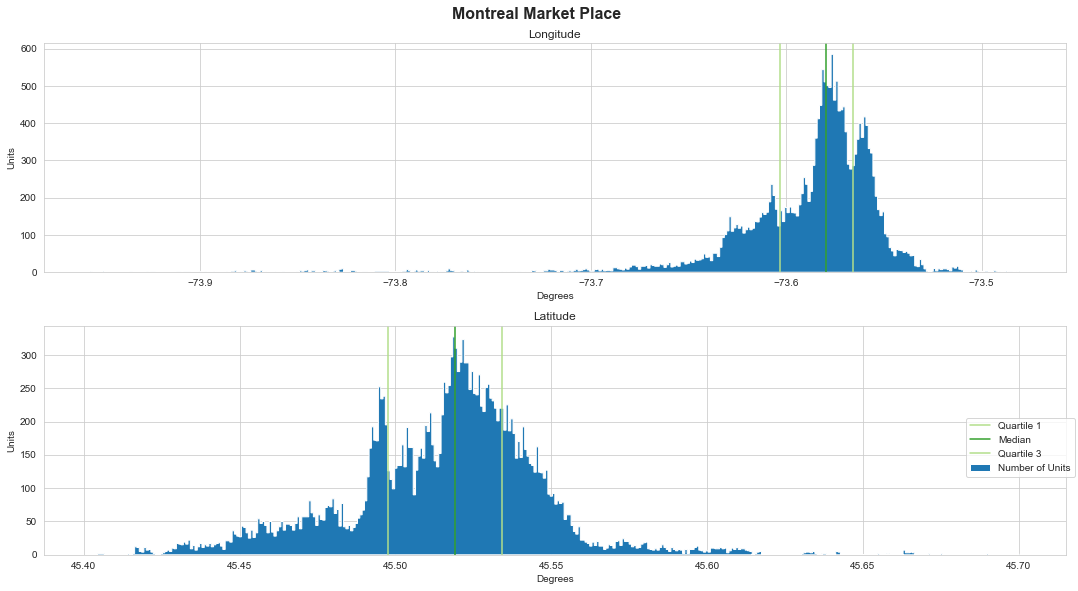

In [17]:
# plotting histogram for longitude with each quartile highlighted
fig = plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
ax0 = plt.hist(longitude_array, bins=400, color='#1f78b4', histtype='stepfilled')

plt.axvline(x=np.quantile(longitude_array, 0.25), c='#b2df8a')
plt.axvline(x=np.quantile(longitude_array, 0.5), c='#33a02c')
plt.axvline(x=np.quantile(longitude_array, 0.75), c='#b2df8a')

plt.xlabel("Degrees")
plt.ylabel("Units")
plt.title("Longitude")

# similar plot for latitude
plt.subplot(2, 1, 2)
ax1 = plt.hist(latitude_array, bins=400, color='#1f78b4', histtype='stepfilled')

plt.axvline(x=np.quantile(latitude_array, 0.25), c='#b2df8a')
plt.axvline(x=np.quantile(latitude_array, 0.5), c='#33a02c')
plt.axvline(x=np.quantile(latitude_array, 0.75), c='#b2df8a')

plt.title("Latitude")
plt.xlabel("Degrees")
plt.ylabel("Units")

fig.suptitle("{}".format(top_market) + " Market Place", fontsize=16, fontweight='bold', ha='center', y=1.02)
fig.legend(["Quartile 1", "Median", "Quartile 3", "Number of Units"], loc=7, bbox_to_anchor=(0.5, 0., 0.5, 0.5))

plt.tight_layout()
# plt.savefig("marketplace_longitude_latitude.png")
plt.show()


Representation of the market

In [18]:
# Used minimums and maximums to take image of map on Google maps
longmin = city["longitude"].min()
longmax = city["longitude"].max()
latmin = city["latitude"].min()
latmax = city["latitude"].max()
longlong = [longmin, longmax]
latlat = [latmin, latmax]



In [19]:
#Determining which quantile to use as limits 
low_quantile = np.quantile(np.array(city["price"]), 0.02)
high_quantile = np.quantile(np.array(city["price"]), 0.98)

Attributing image of each city based on dataframe chosen

In [20]:
if top_market == "Chicago":
    img = mpimg.imread("img/img_chicago.png")
    
elif top_market == "Los Angeles":
    img = mpimg.imread("img/img_los_angeles.png")
    
elif top_market == "Montreal":
    img =mpimg.imread("img/img_montreal.png")
    
elif top_market == "New York":
    img = mpimg.imread("img/img_new_york.png")
    
elif top_market == "Ottawa":
    img = mpimg.imread("img/img_ottawa.png")
    
elif top_market == "Quebec":
    img = mpimg.imread("img/img_quebec_qc.png")
    
elif top_market == "San Francisco":
    img = mpimg.imread("img/img_san_francisco.png")
    
elif top_market == "Toronto":
    img = mpimg.imread("img/img_toronto.png")
    
elif top_market == "Vancouver":
    img = mpimg.imread("img/img_vancouver.png")
    
elif top_market == "D.C.":
    img = mpimg.imread("img/img_washington_dc.png")
    
else:
    "nope"

Showing how markets are defined and concentration of each neighbourhoods

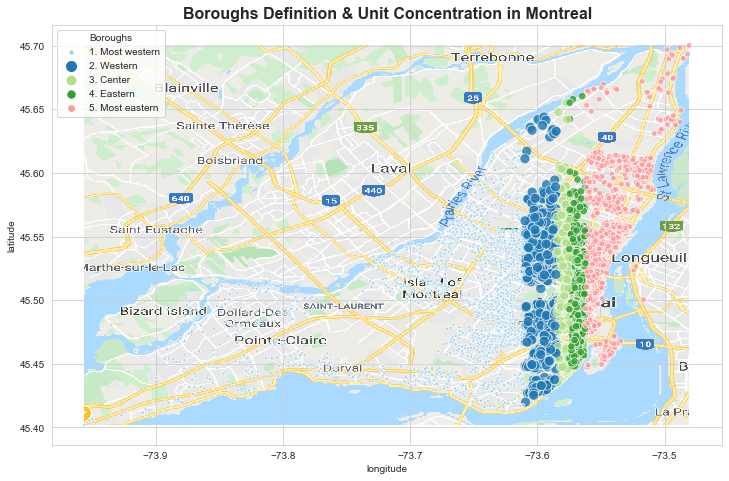

In [21]:
fig, ax3 = plt.subplots(figsize=(12,12))

imgplot = plt.imshow(img, extent=[city['longitude'].min(), city['longitude'].max(), city['latitude'].min(), city['latitude'].max()])
if top_market == 'New York':
    ax3 = sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood_group_cleansed", size="neighbourhood_group_cleansed", sizes=(10,100), data=city, alpha=0.8)
elif top_market != 'New York' and longitude_std > latitude_std:
    ax3 = sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood_group_cleansed", hue_order=["1. Most western", "2. Western", "3. Center", "4. Eastern", "5. Most eastern"], size="neighbourhood_group_cleansed", sizes=(10,100), data=city, alpha=0.8)
else:
    ax3 = sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood_group_cleansed", hue_order=["1. Most southern", "2. Southern", "3. Center", "4. Northern", "5. Most northern"], size="neighbourhood_group_cleansed", sizes=(10,100), data=city, alpha=0.8)

# ax3 = sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood_group_cleansed", size="neighbourhood_group_cleansed", sizes=(10,100), data=city)    

plt.title("Boroughs Definition & Unit Concentration in "+ top_market, fontsize=16, fontweight='bold')
legend = ax3.legend(loc=2)
legend.texts[0].set_text("Boroughs")
plt.show()

Number of listings per borough

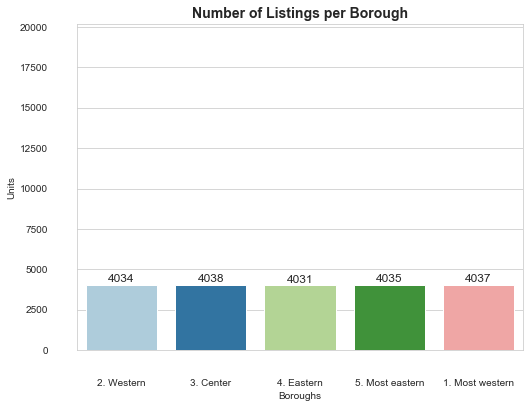

In [22]:
ax1, fig = plt.subplots(figsize=(8,6)) 

sns.barplot(data=city, x="neighbourhood_group_cleansed", y="id", estimator=len)

ax1 = plt.gca()
ax1.set_title("Number of Listings per Borough", fontsize=14, fontweight='bold')
ax1.set_xlabel("Boroughs")
ax1.set_ylabel("Units")
ax1.set_ylim(0,(len(city["id"])))


for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height()*1.01, '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')
ax1.tick_params(axis="both", which="major", pad=25)
plt.show()
# plt.savefig("nb_listing_borough.png")


In [23]:
if boroughs >= 6 or boroughs == 0 :
    print("The number of listings is very similar in each borough as they were calculated to be split evenly among 4 quantiles.")
else:
    print("Manhattan has the highest number of listings.")

The number of listings is very similar in each borough as they were calculated to be split evenly among 4 quantiles.


Plotting average price of units by location while removing the extreme outliers: showing data in between 10th and 90th percentiles.
Used images instead of leafletmap as the data was too heavy to use for it. 

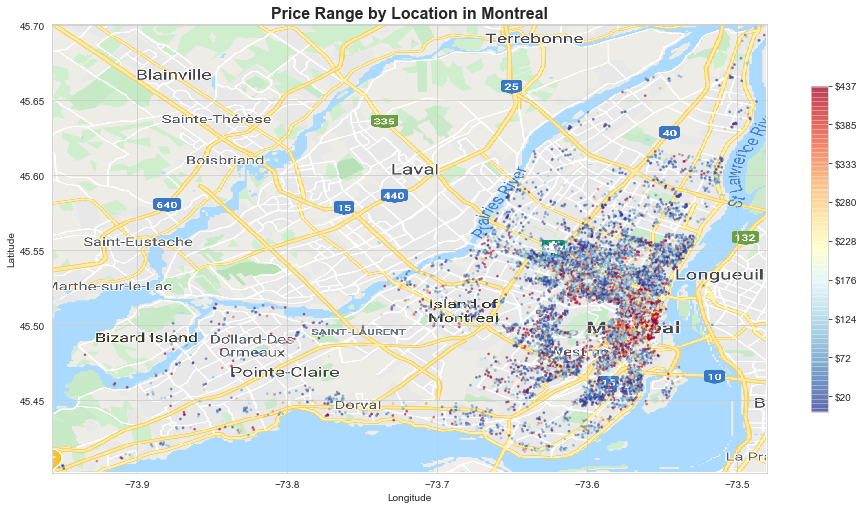

In [24]:
# Map displaying price range of units  
fig, ax4 = plt.subplots(figsize=[16,12])

imgplot = plt.imshow(img, extent=[city["longitude"].min(), city["longitude"].max(), city["latitude"].min(), city["latitude"].max()])
ax4 = plt.scatter(x=city["longitude"], y=city["latitude"], c=city["price"], s=3, cmap=plt.cm.get_cmap('RdYlBu_r'), vmin=np.quantile(np.array(city["price"]), 0.10), vmax=np.quantile(np.array(city["price"]), 0.90), alpha=0.5)
# Display colorbar
cbar = plt.colorbar(shrink=0.5)
# Format colorbar ticks to include '$' in front of number
tick_values = np.linspace(low_quantile, high_quantile, num=10)
cbar.ax.set_yticklabels(['$%d'%v for v in tick_values])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Price Range by Location in {}".format(top_market), fontsize=16, fontweight='bold')
plt.show()
# plt.savefig('price_range_location.png')

### Description: main points about the marketplace 


#1. Number of units in market 

In [25]:
unit_count = "{:,.0f}".format(city["id"].count())

print("Number of units: " + str(unit_count))

Number of units: 20,175


#2. Number of boroughs per market and list of them

In [26]:
new_boroughs = city["neighbourhood_group_cleansed"].nunique()
boroughs_list = sorted(city["neighbourhood_group_cleansed"].unique())
print("Number of boroughs defined : " + str(new_boroughs))


Number of boroughs defined : 5


#3. Number of neighbourhoods

In [27]:
neighbourhood_count = city["neighbourhood_cleansed"].nunique()
print("Number of pre-defined neighbourhoods: " + str(neighbourhood_count))
neighbourhood_examples = city["neighbourhood_cleansed"].head().tolist()
neighbourhood_examples.append("etc.")


Number of pre-defined neighbourhoods: 32


#4. Number of hosts 

In [28]:
hosts_count = "{:,.0f}".format(city["host_id"].nunique())
print("Number of hosts: " + str(hosts_count))

Number of hosts: 13,876


#5. Number of listings per host

In [29]:
listings_per_host_count = city["calculated_host_listings_count"].mean()
# listings_per_host_count = "{:.2f}".format(city["calculated_host_listings_count"].mean())
print("Average number of listings per host: " + str("{:.2f}".format(listings_per_host_count)))


Average number of listings per host: 5.73


#6. Room types definition

In [30]:
room_type = city["room_type"].unique()
print(room_type)

['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']


#7. First and last listing date

In [31]:
first_listing_date = city["host_since"].min().date()
last_listing_date = city["host_since"].max().date()
print("First listing was created on: "+ str(first_listing_date))
print("The last listing to have been added was on: "+ str(last_listing_date))

First listing was created on: 1970-01-01
The last listing to have been added was on: 1970-01-01


#8. Average price city

In [32]:
average_price = city["price"].mean()
# average_price = "${:.2f}".format(average_price)

print("Average price in market: " + "$" + str("{:.2f}".format(average_price)))


Average price in market: $114.06


##. Summary of main points about marketplace

In [33]:
# summary into a table
data = [["number_units", "defined_number_boroughs", "number_neighbourhoods", "number_hosts", "number_listings_per_host", "room_types",  "average_price_city", "first_listing_date", "last_listing_date"]\
       ,[unit_count, new_boroughs, neighbourhood_count, hosts_count, listings_per_host_count, len(room_type), average_price, first_listing_date,last_listing_date]\
       , ["", boroughs_list, neighbourhood_examples, "", "", room_type,  "", "", ""]]
column_names = data.pop(0)

summarized = pd.DataFrame(data, columns=column_names)

summarized.style.set_properties(**{'text-align': 'center'}).hide_index()


number_units,defined_number_boroughs,number_neighbourhoods,number_hosts,number_listings_per_host,room_types,average_price_city,first_listing_date,last_listing_date
"20,175",5,32,"13,876",5.73408,4,114.059,1970-01-01,1970-01-01
,"['1. Most western', '2. Western', '3. Center', '4. Eastern', '5. Most eastern']","['Le Plateau-Mont-Royal', 'Le Sud-Ouest', 'Le Plateau-Mont-Royal', 'Ville-Marie', 'Ville-Marie', 'etc.']",,,['Private room' 'Entire home/apt' 'Shared room' 'Hotel room'],,,


#8. a/ Price range in marketplace

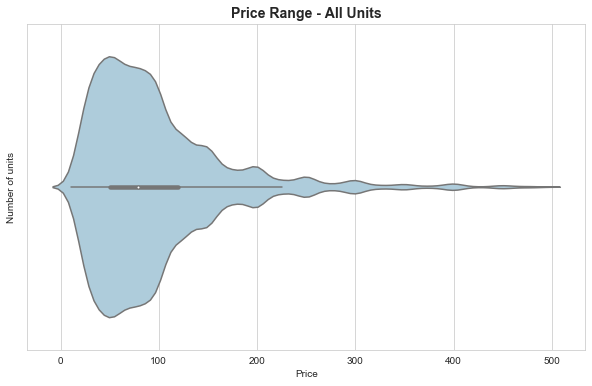

In [34]:
fig = plt.subplots(figsize=(10,6))
sns.violinplot(data=city[city.price < high_quantile], x="price")
plt.xlabel('Price')
plt.ylabel("Number of units")
plt.title("Price Range - All Units", fontsize=14, fontweight='bold')
plt.show()
# plt.savefig("price_range_all.png")

#8. b/ Price range by roomtype

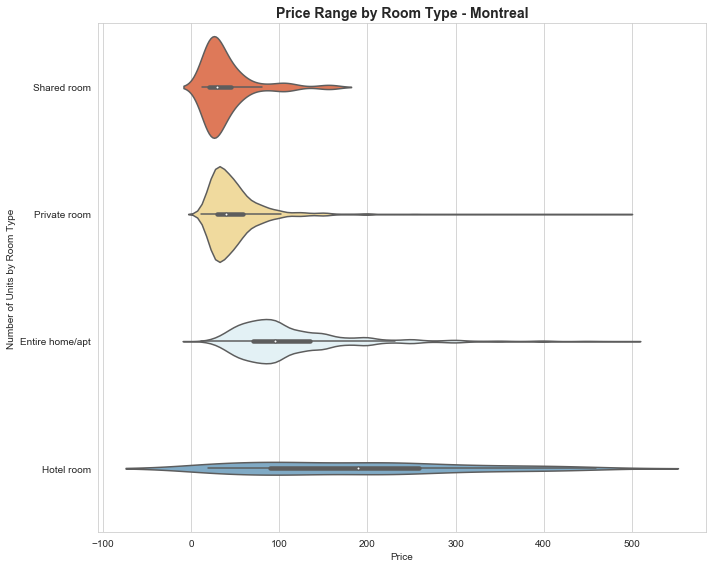

In [35]:
ax1, fig = plt.subplots(figsize=(10,8))

ax1 = sns.violinplot(x="price", y="room_type", data=city[city["price"] < high_quantile], palette='RdYlBu', order=["Shared room", "Private room", "Entire home/apt", "Hotel room"])

plt.title("Price Range by Room Type - {}".format(top_market), fontsize=14, fontweight='bold')
plt.xlabel("Price")
plt.ylabel("Number of Units by Room Type")
plt.tight_layout()
plt.show()
# plt.savefig("price_range_room_type.png")

#8. c/ Average price by room type and by neighbourhood

In [36]:
result = city.groupby(["neighbourhood_group_cleansed"])["price"].aggregate(np.mean).reset_index().sort_values("price", ascending=False,)

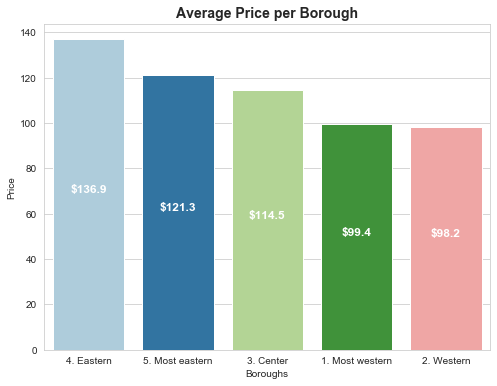

In [37]:
ax, fig = plt.subplots(figsize=(8,6))

sns.barplot(data=city, x="neighbourhood_group_cleansed", y="price", ci=False, order=result["neighbourhood_group_cleansed"])
# Get current axis on current figure
ax = plt.gca()
ax.set_title('Average Price per Borough',fontsize=14, fontweight="bold")
ax.set_xlabel('Boroughs')
ax.set_ylabel('Price')


# Iterate through list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()*0.5, '$%0.1f' % float(p.get_height()),
           fontsize=12, ha='center', va='bottom', color='white', fontweight = 'bold')

plt.show()
# plt.savefig('avg_price_borough.png')



#9. Charging for additional persons / Fee for extra adult

#9. a/Percentage of units that charge for additional.
Filtering on units that charge for an extra person when it can accommodate 2 or more

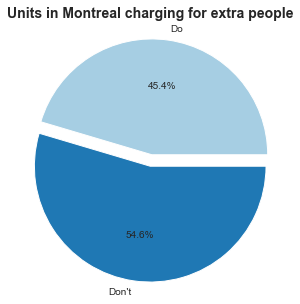

In [38]:
fig = plt.subplots(figsize=(5,5))

extra_people_fee_true = city[(city["extra_people"].notna() == True) & (city["extra_people"] != 0) & (city["accommodates"] >= 2) ].reset_index()

total_extra_people_fee = [len(extra_people_fee_true), (len(city["extra_people"]) - len(extra_people_fee_true) )]
total_extra_people_labels = ["Do", "Don't"]


plt.pie(total_extra_people_fee, autopct='%0.1f%%', labels=total_extra_people_labels, explode = (0, 0.1))
plt.axis('equal')

plt.title("Units in {} charging for extra people".format(top_market), fontsize=14, fontweight='bold')
plt.show()
# plt.savefig("Units_charging_extra_people.png")

#9. b/How many guests are mostly included in the unit's price

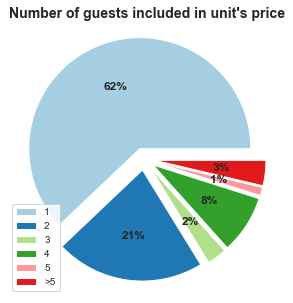

In [39]:
def guests_count():  
    fig = plt.subplots(figsize=(5,5))

    guests_included = np.array(city["guests_included"].to_list())
    guests_count = city.groupby("guests_included").id.count()
    
    if len(guests_count) > 5:
        guests_10_list= np.append(guests_count[:5], [guests_count[5:].sum()])
#         print(len(guests_10_list))
        guests_10_labels = np.append(np.array(range(len(guests_10_list[:5])))+1, [">5"])
#         print(guests_10_labels)
        exploding = [0.1 for x in guests_10_labels]
        plt.pie(guests_10_list, autopct='%d%%', labeldistance=7, textprops=dict(fontsize=12, fontweight='bold'), explode=exploding)
        plt.legend(guests_10_labels, loc=3)
    else:
        guests_count_list = guests_count.to_list()
        guests_incl_labels = np.array(range(len(guests_count_list))) +1
        exploding = [0.1 for x in guests_incl_labels]
        plt.pie(guests_count_list, autopct='%d%%', labeldistance=1.1, textprops=dict(fontsize=12, fontweight='bold'), explode=exploding)
        plt.legend(guests_incl_labels, loc=3)
        
    plt.axis('equal')
    plt.title("Number of guests included in unit's price", fontsize=14, fontweight='bold')
    
    
guests_count()
plt.show()

#9. c/ Fee range charged per extra adult by neigbourhood

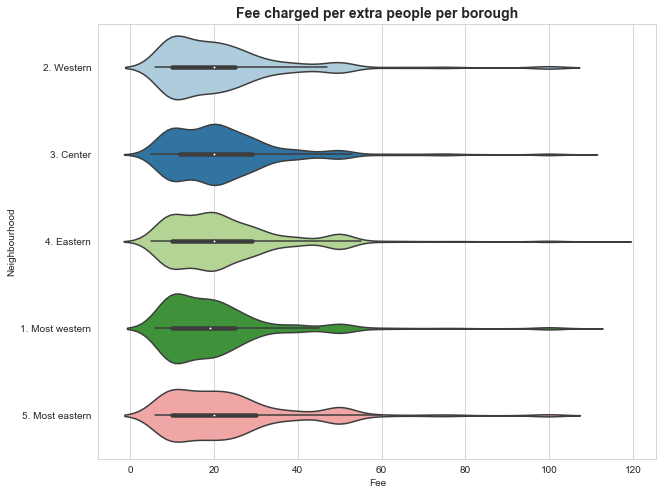

In [40]:
extra_ax, fig = plt.subplots(figsize=(10,8))
extra_ax = sns.violinplot(x="extra_people", y="neighbourhood_group_cleansed", data=extra_people_fee_true[extra_people_fee_true["extra_people"] < 120])

extra_ax.set_xlabel("Fee")
extra_ax.set_ylabel("Neighbourhood")

plt.title("Fee charged per extra people per borough", fontsize=14, fontweight='bold')
plt.show()
# plt.savefig("extra_people_fee.png")

#10. Cleaning fee 
#10. a/Percentage of units that apply a cleaning fee 

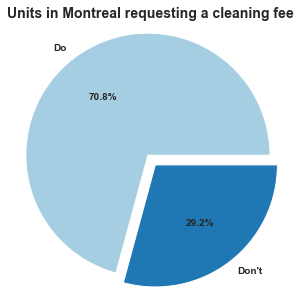

In [41]:
#New df if cleaning fee or not 
fig = plt.subplots(figsize=(5,5))

cleaning_fee_true = city[(city["cleaning_fee"].notna() == True) & (city["cleaning_fee"] != 0) ].reset_index()
cleaning_fee_false = city[(city["cleaning_fee"].notna() != True) | (city["cleaning_fee"] == 0) ].reset_index()
total_cleaning_list = [len(cleaning_fee_true), (len(city["cleaning_fee"]) - len(cleaning_fee_true) )]
total_cleaning_labels = ["Do", "Don't"]


plt.pie(total_cleaning_list, autopct='%0.1f%%', labels=total_cleaning_labels, explode = (0, 0.1), textprops=dict(fontweight="bold"))
plt.axis('equal')

plt.title("Units in {} requesting a cleaning fee".format(top_market), fontsize=14, fontweight='bold')
plt.show()
# plt.savefig("cleaning_fee_percent.png")

#10. b/ Cleaning fee range per neighbourhood 
Training on indicating maximum outliers 

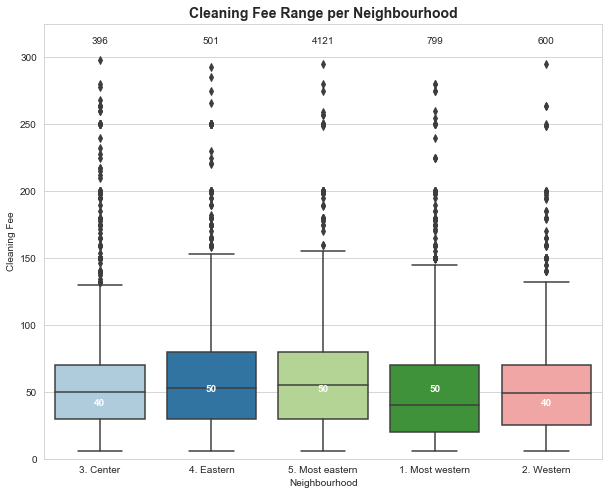

In [42]:
# plotting boxplots to evaluate spread charge for cleaning fee per neighbourhood 
cleaning_ax, fig = plt.subplots(figsize=(10,8))
cleaning_ax = sns.boxplot(data=cleaning_fee_true[cleaning_fee_true['cleaning_fee'] < 300], x="neighbourhood_group_cleansed", y="cleaning_fee")

cleaning_ax.set_ylim(city['cleaning_fee'].min(), 325)
cleaning_ax.set_ylabel("Cleaning Fee")
cleaning_ax.set_xlabel("Neighbourhood")

cleaning_ax.set_title("Cleaning Fee Range per Neighbourhood", fontsize=14, fontweight="bold")

# indicating median labels amount for cleaning fee 
medians = city.groupby(['neighbourhood_group_cleansed'], sort=False)['cleaning_fee'].median().values
median_labels = medians.astype(int)

# positioning medians
position = range(len(medians))
for tick, label in zip(position,cleaning_ax.get_xticklabels()):
    cleaning_ax.text(position[tick], medians[tick] , median_labels[tick], horizontalalignment='center', size=10, color='w', weight='bold')
    
# indicating maximum labels amount for cleaning fee
max_cleaning_fee = city.groupby(["neighbourhood_group_cleansed"], sort=False)["cleaning_fee"].max().values
max_cleaning_label = max_cleaning_fee.astype(int)

# positining maximums
for tick, label in zip(position, cleaning_ax.get_xticklabels()):
    cleaning_ax.text(position[tick], 310, max_cleaning_label[tick], horizontalalignment='center')

plt.show()
# plt.savefig("cleaning_fee_neighbourhood.png")

#10. c/ Details of listings that don't charge a cleaning fee

In [43]:
cleaning_fee_false = city[(city["cleaning_fee"].isna() == True) | (city["cleaning_fee"] == 0) ].reset_index()


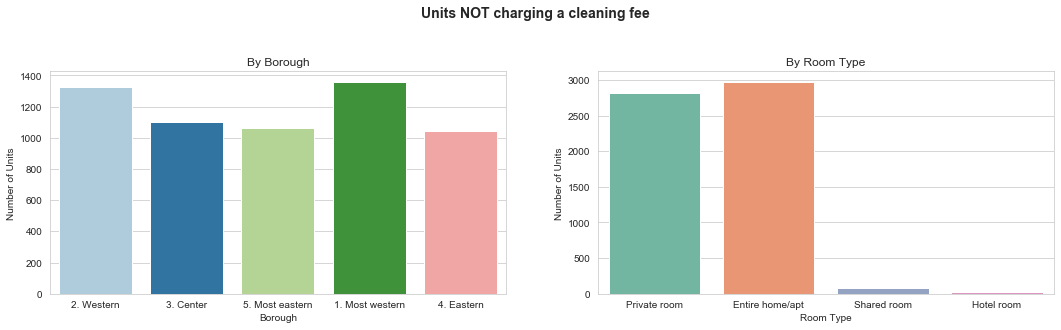

In [44]:
fig = plt.subplots(figsize=(18,9))
plt.suptitle("Units NOT charging a cleaning fee", fontsize=14, fontweight='bold')

ax1 = plt.subplot(2,2,1)
sns.barplot(data=cleaning_fee_false, x="neighbourhood_group_cleansed", y="id", estimator=len)


ax1.set_title("By Borough")
ax1.set_xlabel("Borough")
ax1.set_ylabel("Number of Units")

ax2 = plt.subplot(2,2,2)
sns.barplot(data=cleaning_fee_false, x="room_type", y="id", estimator=len, palette='Set2')

ax2.set_title("By Room Type")
ax2.set_xlabel("Room Type")
ax2.set_ylabel("Number of Units")

plt.show()

### Further analysis - a few questions

#### 1. Do units that don't charge a cleaning fee have a lower ranking? 

First of, average cleaning fee 

In [45]:
cleaning_fee_rate = city["cleaning_fee"].mean()
print("{:.2f}".format(cleaning_fee_rate))

54.07


Overall rating based on cleaning fee: is there a lower rating when no cleaning fee, or vice versa? 


In [46]:
overall_score_cleaning_true = round(cleaning_fee_true["review_scores_rating"].mean(),1)
overall_score_cleaning_false = round(cleaning_fee_false["review_scores_rating"].mean(),1)

overall_rating_difference_cleaning = round(overall_score_cleaning_false -overall_score_cleaning_true, 1)

In [47]:
if overall_rating_difference_cleaning < 0:
    print("Units that charge for cleaning fee have a higher overall score ("+ str(overall_score_cleaning_true) + ") than the ones that don't ("+ str(overall_score_cleaning_false) + ").")
else:
    print("Units that don't charge for cleaning fee do not actually rank lower than the ones that do. They are ranked " + str(overall_rating_difference_cleaning) + " points higher.")


Units that charge for cleaning fee have a higher overall score (93.8) than the ones that don't (93.2).


In [48]:
# Reviewing all rating scores for both types to review where this is coming from. 

In [49]:
scores_all = ["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]

scores_cleaning_true = []
scores_cleaning_false = []

def ratings(df_true, df_false):
    for column in scores_all:
        column_df_true = round(df_true[column].mean(),1)
        column_df_false = round(df_false[column].mean(),1)
        scores_cleaning_true.append(column_df_true)
        scores_cleaning_false.append(column_df_false)
        
        
ratings(cleaning_fee_true, cleaning_fee_false)
list_scores_cleaning_true = zip(scores_all, scores_cleaning_true)
list_scores_cleaning_false = zip(scores_all, scores_cleaning_false)



Rating score by category

In [50]:
score_names = ["Accuracy", "Cleanliness", "Check-in", "Communication", "Location", "Value"]

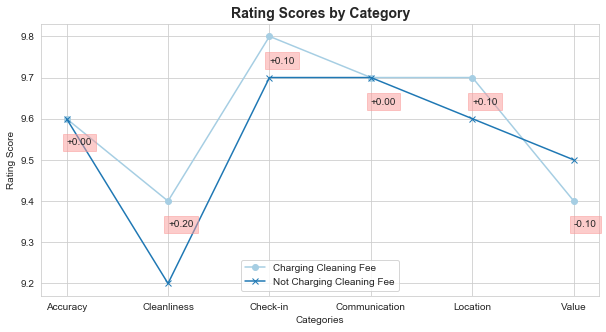

In [51]:
fig = plt.subplots(figsize=(10,5))
ax = plt.subplot()


plt.plot(scores_all, scores_cleaning_true, 'o-')
plt.plot(scores_all, scores_cleaning_false, '-x')

ax.set_xticklabels(score_names, rotation=0)
plt.legend(["Charging Cleaning Fee", "Not Charging Cleaning Fee"], loc=8)
plt.title("Rating Scores by Category", fontsize=14, fontweight='bold')
# plt.savefig('ratings_category_cleaning.png')

ax.set_xlabel("Categories")
ax.set_ylabel("Rating Score")

scores_cleaning_true = np.array(scores_cleaning_true)
scores_cleaning_false = np.array(scores_cleaning_false)


diff_true_v_false = np.array(scores_cleaning_true - scores_cleaning_false)

for a, b, c in zip(scores_all, diff_true_v_false, scores_cleaning_true):
    plt.text(a, c*0.9933, "{:+.2f}".format(b), fontsize=10, bbox=dict(color='#fb9a99', alpha=0.5))

plt.show()

#### 2. Hypothesis: charging higher room rate when not charging cleaning fee or vice versa? 


And following the hypothesis that room rate should be higher when not charging a cleaning fee (as rate should be absorbed in room rate), verifying which option is more affordable:
By calculating total room rate (for units charging cleaning fee: units yes + cleaning fee) 
and comparing them to units not charging cleaning fee. 

In [52]:
price_cleaning_true = round(cleaning_fee_true['price'].mean(),1)
price_cleaning_false = round(cleaning_fee_false['price'].mean(),1)

pct_diff_price_c_true_v_false = round((price_cleaning_true - price_cleaning_false)/price_cleaning_false * 100, 1)

total_room_rate_yes = price_cleaning_true + cleaning_fee_rate
total_room_rate_no = price_cleaning_false
diff_total_room_rate = total_room_rate_yes - total_room_rate_no 


print("Average price of units charging a cleaning fee: $" + str(price_cleaning_true))
print("Average price of units that do not charge for cleaning: $" + str(price_cleaning_false)+"\n")

print("Total room rate units charging cleaning fee (room rate + cleaning fee): $" + "{:.1f}".format(total_room_rate_yes) + ".")
print("Total room rate units not charging cleaning fee (room rate): $" + "{:.1f}".format(total_room_rate_no) + ".\n")
    

if pct_diff_price_c_true_v_false < 0:
    print("Units in "+ top_market +" that charge for a cleaning fee on top of the room rate indeed charge a lower room rate ("+ '%s %%' % pct_diff_price_c_true_v_false +" lower) than those that don't, absorbing part of the cleaning fee in the room rate.")
    if diff_total_room_rate > 0:
        print("\nHowever, with a cleaning fee on average at $" + "{:.1f}".format(cleaning_fee_rate) + " in " + top_market + ", it is more profitable for hosts to charge for a cleaning fee than absorb it in the room rate as units are in total $"+ "{:.1f}".format(diff_total_room_rate)+ " higher than those not charging for it.")
    else: 
        print("\nwWith a cleaning fee on average at $" + "{:.1f}".format(cleaning_fee_rate) + " in " + top_market + ", it is more affordable to book a unit that doesn't charge for cleaning as total room rate for these units is in total $"+ "{:.1f}".format(diff_total_room_rate)+ " lower than those charging for it.")
    
else:
    print("Units in " + top_market + " that charge for a cleaning fee do not charge a lower room rate - quite the opposite actually: room rate is " + '%s%%'% pct_diff_price_c_true_v_false + " higher than units not charging for one.")


Average price of units charging a cleaning fee: $122.7
Average price of units that do not charge for cleaning: $93.1

Total room rate units charging cleaning fee (room rate + cleaning fee): $176.8.
Total room rate units not charging cleaning fee (room rate): $93.1.

Units in Montreal that charge for a cleaning fee do not charge a lower room rate - quite the opposite actually: room rate is 31.8% higher than units not charging for one.


In [ ]:
print("Limit of this analysis: this study should be further compared by borough and room type to ensure each confirm this theory or at the contrary that it does not skew the data.")


Limit of this analysis: this study should be further compared by borough and room type to ensure each confirm this theory or at the contrary that it does not skew the data.


#### 3. More into detail. Further units description 

#1. Average size by room type by neighbourhood

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=city, x="neighbourhood_group_cleansed", y="square_feet", hue="room_type", ci=None)
plt.title("Average Size by Room Type and Neighbourhood", fontsize=14, fontweight='bold')

plt.xlabel("Neighbourhood")
plt.ylabel("Average Size (Sq Feet)")

legend = ax.legend(loc=2)
plt.show()

#2. a/Part of hosts that are Superhosts - overall 

In [ ]:
fig = plt.subplots(figsize=(8,5))

superhost_true = len(city[city['host_is_superhost'] == "t"])
superhost_false = len(city[city['host_is_superhost'] == "f"])

superhost_all = np.array([superhost_true, superhost_false])


plt.pie(superhost_all, autopct='%d%%', explode = (0, 0.1))
plt.title("Part of hosts that are superhost in {}".format(top_market), fontsize=14, fontweight='bold')
plt.legend(["Superhost", "Not"], loc=4)

plt.show()

#2. b/Part of hosts that are superhosts by borough

In [ ]:
superhost_true_boroughs = np.array(city[city["host_is_superhost"] == "t"].groupby("neighbourhood_group_cleansed", sort=False)["id"].count())
superhost_false_boroughs = np.array(city[city["host_is_superhost"] == "f"].groupby("neighbourhood_group_cleansed", sort=False)["id"].count())

superhost_all = superhost_true_boroughs + superhost_false_boroughs

superhost_true_boroughs_percent = superhost_true_boroughs / superhost_all
superhost_false_boroughs_percent = superhost_false_boroughs / superhost_all

superhost_true_percent_labels = superhost_true_boroughs_percent *100


fig, ax = plt.subplots(figsize=(7,5))
superhost_f = ax.bar(boroughs_list, superhost_true_boroughs_percent)
superhost_t = ax.bar(boroughs_list, superhost_false_boroughs_percent, bottom=superhost_true_boroughs_percent)


ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.legend(["Superhost", "Not"], loc=4)
ax.set_title("Part of hosts that are superhost", fontsize=14, fontweight='bold')

def autolabel(hosts_percent):
    for percent in hosts_percent:
        height = percent.get_height()
        ax.annotate('{:.0%}'.format(height),
                   xy=(percent.get_x() + percent.get_width()/2, height), 
                   xytext=(4,-12), 
                   textcoords='offset points',
                   ha='center', va='center',
                   c='w', fontsize=12, fontweight='bold')
        
autolabel(superhost_t)
autolabel(superhost_f)

plt.show()

#3.a- Average number of listings per host per borough 

In [ ]:
fig = plt.subplots(figsize=(16,4))

# Average Number of Units per Host 
# All hosts
ax1 = plt.subplot(1,2,1)
sns.barplot(data=city, x="neighbourhood_group_cleansed", y="calculated_host_listings_count", ci=None)
ax1.tick_params(labelsize=12, rotation=30)
ax1.set_title("All Hosts")
plt.suptitle("Average Number of Listings per Host per Neighbourhood", fontsize=14, fontweight='bold')

ax1.set_xlabel("Boroughs")
ax1.set_ylabel("Units per Host")

# Superhosts only
ax2 = plt.subplot(1,2,2)
ax2 = sns.barplot(data=city[city["host_is_superhost"] == 't'], x="neighbourhood_group_cleansed", y="calculated_host_listings_count", ci=None)
ax2.set_title("Superhosts Only")
ax2.tick_params(labelsize=12, rotation=30)

ax2.set_xlabel("Boroughs")
ax2.set_ylabel("Units per Superhost")

plt.show()

In [ ]:
#4. Number of units per year: when market grew on Airbnb 

In [ ]:
city["host_first_year"] = pd.DatetimeIndex(city["host_since"]).year
year = city["host_first_year"].dropna().unique()

In [ ]:
# 2 variables will be holding values: 1 for the total number of rooms per year and 1 for rooms per year per room type 
total_room_num = []
room_types_num = []

def var_filter(room):
    room_variable = city[city["room_type"] == room].reset_index()

    for y in year:
        x_axes_year = city[city["host_first_year"] == y].reset_index()
        x_room_year = room_variable[room_variable["host_first_year"] == y].reset_index()
        total_room_num.append(len(x_axes_year))
        room_types_num.append(len(x_room_year))


# call function for each room type in list room_type
for x in room_type:
    var_filter(x)


# due to for loop, the lists are called 4 times. selecting only the corresponding ones
total_room_num = total_room_num[:len(year)]
private_num = room_types_num[:len(year)]
entire_num = room_types_num[len(year):(len(year)*2)]
shared_num = room_types_num[len(year)*2:(len(year)*3)]
hotel_num = room_types_num[len(year)*3:]

shared_bottom = np.add(entire_num, private_num)
hotel_bottom = np.add(shared_bottom, shared_num)


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
# plotting each bar for count of unit per room type per year 
plt.bar(year, entire_num)
plt.bar(year, private_num, bottom=entire_num)
plt.bar(year, shared_num, bottom=shared_bottom)
plt.bar(year, hotel_num, bottom=hotel_bottom)

# plotting line for totals 

plt.plot(year, total_room_num, linewidth=0, marker='s', alpha=0.5, color='#fb9a99')

legend = np.append(["Total new listings"], room_type)
plt.legend(legend)

ax.set_xticks(year)
ax.set_xlabel("Year")
ax.set_ylabel("Number of New Listings")
ax.set_ylim(0, max(total_room_num)*1.1)

# indicating values of total new units each year
for i, j in zip(year, total_room_num):
    plt.text(i, j*1.03, '+' +str(j), fontsize=10, bbox=dict(color='#fb9a99', alpha=0.5))

plt.title("New listings per year in " + top_market, fontsize=15, fontweight='bold')

# plt.savefig('new_listings_year_NY')
plt.show()

Training on groupby and pivot tables

In [ ]:
# 5. Average length of stay per borough

In [ ]:
min_nights_borough = np.ceil(city.groupby(['neighbourhood_group_cleansed']).minimum_nights.mean()).reset_index()
min_nights_borough

In [ ]:
# 6. Correlation between average score and response time

In [ ]:
# Reviewing overall scores and verifying whether communication is the score impacting overall results
communication_score = np.round(city.groupby(["host_response_time", "host_is_superhost"]).agg({"review_scores_rating": ['mean'], "review_scores_communication": ['mean']}),1).reset_index()

pivoted_communication = communication_score.pivot(columns="host_is_superhost",
                         index="host_response_time",
                         values=["review_scores_rating", "review_scores_communication"])

pivoted_communication.style.set_properties(**{'text-align': 'center'})

In [ ]:
print("Unsurprisingly, hosts who take the longest to respond generally have lower Overall scores ratings. Difference in ratings between regular and super hosts is drastic: up to 5 pts difference for host response within an hour. Hosts who are superhosts (naturally) have  higher scores."
     "\n\nHowever, communication is not necessarily the score dragging scores down as they are generally similar between regular and superhosts.")


In [ ]:
# 7. Correlation between profile picture and number of reviews by month
# a/ Overall

In [ ]:
review_pp = np.round(city.groupby(["host_has_profile_pic"])\
                     .reviews_per_month.mean().reset_index(),1)
review_pp.columns = ["Host_Has_Profile_Pic", "Reviews_Month"]
review_pp

In [ ]:
print("Hosts who do not have a profile picture do not record a much lower number of reviews per month overall")


In [ ]:
# b/ By borough
review_pp_borough = np.round(city.groupby(["host_has_profile_pic", \
                                           "neighbourhood_group_cleansed"])\
                             .reviews_per_month.mean().reset_index(),1)
review_pp_borough.columns = ["Profile_pic", "Borough", "Reviews_Per_Month"]
review_pp_borough

In [ ]:
print("However when looking at details by borough, it seems Queens recorded a particularly high number of reviews for per month (3.2 without profile picture vs 2.0 with one, on average), skewing all other boroughs' average which do indicate there is a lower number of reviews per month when the host doesn't have a profile picture.")

Training on pivot table

In [ ]:
# 8. Average LOS required by borough by bed type

In [ ]:
LoS_borough_bed = np.round(pd.pivot_table(city, columns="bed_type", values = 'minimum_nights',  index='neighbourhood_group_cleansed', aggfunc='mean', margins=True, fill_value=0),1)
LoS_borough_bed



In [ ]:
print("The average length of stay requested overall is 7.4 nights, with Manhattan having the highest one: 9.0. Futons are actually the bed type requesting the highest minimum night stay, higher than real beds (+0.5pts), and Airbeds require a higher length of Stay than Couches, which require the lowest number of nights stay.")

In [ ]:
# 9. Average rating by borough by bed type

In [ ]:
rating_borough_LOS = np.round(pd.pivot_table(city[city['minimum_nights'] < 10], values='review_scores_rating', index= 'bed_type', columns='neighbourhood_group_cleansed', aggfunc=np.mean, fill_value=0, margins=True).reset_index(),1)
rating_borough_LOS


In [ ]:
print("Staten Island and Brooklyn record the highest rating scores overall. Manhattan records a score below average: 93.7. \nThis table doesn't take into account the number of reviews written by borough.  ")

In [ ]:
# 10.Weekly price discount

In [ ]:
# number of units that charge weekly price vs nightly price, and average discount applied by 

In [ ]:
# creating 3 new columns: is_weekly_price, weekly_price_if_nightly, weekly_percent_discount
# is_weekly_price: True/False if unit offers a weekly_price 
# weekly_price_if_nightly: theoretical weekly rate if weekly rate was 7 times nightly rate 
# weekly_percent_discount: weekly discount vs weekly if daily rate times 7 

In [ ]:
city['is_weekly_price'] = city['weekly_price'].apply(lambda x: False if np.isnan(x) else True)

In [ ]:
city['weekly_price_if_nightly'] = city.price * 7

In [ ]:
city['weekly_percent_discount'] = np.round(100*(city['weekly_price'] - city['weekly_price_if_nightly']) / city['weekly_price_if_nightly'],1)

In [ ]:
# Part of units that offer a weekly discount 

In [ ]:
weekly_price_counts = city.groupby(['neighbourhood_group_cleansed', 'is_weekly_price']).price.count().reset_index()
weekly_count_pivot = weekly_price_counts.pivot(columns='is_weekly_price',
                                              index='neighbourhood_group_cleansed', 
                                              values='price'
                                              ).reset_index()

weekly_count_pivot.columns = ["borough", "no_weekly_rate", "yes_weekly_rate"]

In [ ]:
weekly_count_pivot['%_offering_weekly'] = np.round(100* (weekly_count_pivot['yes_weekly_rate'] / (weekly_count_pivot['yes_weekly_rate'] + weekly_count_pivot['no_weekly_rate'])),1)
weekly_count_pivot.sort_values("%_offering_weekly")


In [ ]:
# And among those who do offer weekly discounts, how much are they

In [ ]:
# filter on units that offer a weekly rate
is_weekly_discount = city[city['is_weekly_price'] == True][["neighbourhood_group_cleansed","price", "weekly_percent_discount"]].reset_index()

# average weekly discount per borough
is_weekly_discount_average = np.round(is_weekly_discount.groupby(["neighbourhood_group_cleansed"]).weekly_percent_discount.mean().reset_index(),2)
is_weekly_discount_average.sort_values("weekly_percent_discount")

In [ ]:
print("Despite Brooklyn and Manhattan having the highest number of units offering weekly discounts, they are the ones offering the lowest discounts - particularly Manhattan.")

#### 4. Hypothesis Testing

In [ ]:
# A/B Test like categories

In [ ]:
# 1. Superhosts

In [ ]:
superhosts_counts = city.groupby('host_is_superhost').id.count().reset_index()
superhosts_counts


In [ ]:
# to delete

In [ ]:
superhosts_melt = pd.melt(frame=superhosts_counts, id_vars=['host_is_superhost'], value_vars=['id'], var_name='id', value_name='number_of_units')

In [ ]:
# above to delete

In [ ]:
plt.pie(superhosts_counts['id'].values, autopct='%0.2f%%', labels=['False', 'True'])
plt.axis('equal')
plt.legend(['False', 'True'])
plt.title('Part of Superhosts')
plt.show()

In [ ]:
# do Superhosts have more than 1 listing, and if so is this more than regular hosts? 

In [ ]:
city['more_than_one_listing'] = city['host_total_listings_count'].apply(lambda x: 'more_than_one' if x > 1 else 'one')


In [ ]:
more_counts = city.groupby(['host_is_superhost', 'more_than_one_listing']).id.count().reset_index()



In [ ]:
more_than_one_pivot = more_counts.pivot(columns='more_than_one_listing',
                                       index='host_is_superhost',
                                       values='id').reset_index()


In [ ]:
more_than_one_pivot['total'] = more_than_one_pivot['more_than_one'] + more_than_one_pivot['one']
more_than_one_pivot['percent_more_than_one'] = more_than_one_pivot['more_than_one'] / more_than_one_pivot['total']

more_than_one_pivot

In [ ]:
# Verifying whether the difference between hosts who own more than one listing and superhosts who do, is significant


In [ ]:
# combining data into contingency table
a = more_than_one_pivot.values

a_false = a[0][1:3].tolist()
a_true = a[1][1:3].tolist()

a_table = np.vstack((a_true, a_false))


In [ ]:
from scipy.stats import chi2_contingency
chi2, morethanone_pval, dof, expected = chi2_contingency(a_table)


In [ ]:
if morethanone_pval < 0.05:
    print("There is significantly more superhosts in {}".format(top_market) + " who own more than 1 listing than regular hosts.")
else:
    print("The part of superhosts who own more than 1 listing is similar to that of regular hosts")


In [ ]:
# 2. Instant Bookable 

In [ ]:
instant_counts = city.groupby('instant_bookable').id.count().reset_index()
instant_counts

In [ ]:
instant_labels = ['Not instant', 'Instant']
plt.pie(instant_counts['id'].values, autopct='%.2f%%')

plt.axis('equal')
plt.legend(instant_labels)
plt.title('Instant bookable units')

plt.show()

In [ ]:
# Are units that are instantly bookable significantly more expensive?

In [ ]:
adr_instant = city.groupby('instant_bookable').agg({'price':['mean', 'std']})
adr_instant

In [ ]:
# getting price for not_instant_price and instant_price

In [ ]:
not_instant_price = city[city['instant_bookable'] == 'f']['price']
instant_price = city[city['instant_bookable'] == 't']['price']


In [ ]:
not_inst_price_std = adr_instant.values[0][1]
inst_price_std = adr_instant.values[1][1]

not_inst_price_mean = adr_instant.values[0][1]
inst_price_mean = adr_instant.values[1][1]

variation_std = not_inst_price_std/inst_price_std


In [ ]:
# ANOVA
from scipy.stats import f_oneway

In [ ]:
tstat, instant_pval = f_oneway(not_instant_price, instant_price)

In [ ]:
if (instant_pval < 0.05) and (inst_price_mean > not_inst_price_mean):
    print('Unit prices are significantly higher when unit has option to be bookable instantly.')
elif (instant_pval < 0.05) and (inst_price_mean < not_inst_price_mean):
    print('Unit prices are significantly lower when unit has option to be bookable instantly. It may not be a good option to opt for this feature as a host.')
else:
    print('no significant difference')

In [ ]:
# verifying numerical hypothesis test could be applied there

In [ ]:
if variation_std >= 0.9 or variation_std <0.9 or variation_std >=1.1 or variation_std < 1.1:
    print("There is a limit to the performed ANOVA test. The price standard deviations are not close enough to each other: " + "{:.2%}".format(variation_std) + " variation.")
else: 
    print("Standard deviations from the 2 groups are close enough to estimate the test is representative.")


In [ ]:
# is the significant difference due to hotel rooms?

In [ ]:
# Tukey's Range Test to find out which room type may be impacting price difference.

In [ ]:
# formatting room_types so can be used
city['room_type'] = city['room_type'].replace("[/ ]", "_", regex=True).str.lower()
cleaned_room_type = city['room_type'].unique()


In [ ]:
# creating one variable per room_type equal to price corresponding to that room type

f = {}
for x, y in zip(cleaned_room_type, range(len(cleaned_room_type))):
    f["price_{0}".format(x)] = city[city['room_type'] == cleaned_room_type[y]]['price']

f_room_keys = list(f)[0:len(cleaned_room_type)]
f_room_values = list(f.values())[0:len(cleaned_room_type)]


In [ ]:
prices_rooms = np.concatenate(f_room_values)
price_labels = [f_room_keys[0]] * len(f_room_values[0]) + [f_room_keys[1]] * len(f_room_values[1]) + [f_room_keys[2]] * len(f_room_values[2]) + [f_room_keys[3]] * len(f_room_values[3])



In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
tukey_results = pairwise_tukeyhsd(prices_rooms, price_labels, 0.05)

In [ ]:
print(tukey_results)

In [ ]:
print("The Tukey's Range test shows we can reject the hypothesis that hotels drove the significantly different price range. \
    \nPrices for all room types significantly differ from one another, except for private and shared rooms.")


In [ ]:
# Work in progress

In [ ]:
# Working on understanding better revenue - not finalized yet
# filtering on columns will need so it's easier to review what is needed

In [ ]:
city['revenue_past'] = city['price'] * city['minimum_nights'] * city['number_of_reviews']
city['roomnights_past'] = city['minimum_nights'] * city['number_of_reviews']


In [ ]:
# monthly
city['revenue_month_past'] = city['price'] * city['minimum_nights'] * city['reviews_per_month']
city['roomnights_month_past'] = city['minimum_nights'] * city['reviews_per_month']

In [ ]:
df_revenue = city[['host_id', 'host_is_superhost', 'price', 'weekly_price', 'monthly_price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'reviews_per_month', 'is_weekly_price', 'roomnights_past', 'revenue_past', 'revenue_month_past', 'roomnights_month_past']]
# df_revenue



In [ ]:
df_revenue[['number_of_reviews', 'reviews_per_month', 'minimum_nights', 'price']].mean()

In [ ]:
# Work in progress

In [ ]:
# word count

In [ ]:
city['TV'] = city.amenities.apply(lambda x: True if 'TV' in x else False)
percent_is_TV = len(city[city['TV'] == True]) / len(city['TV'])
percent_is_TV

In [ ]:
# Work in progress #2: getting list of most popular amenities in order to
# use them for machine learning, linear regression model 

In [ ]:
city['amenities'].replace('[\{}]','', regex=True, inplace=True)

In [ ]:
city['amenities'] = city['amenities'].str.split(r'[,]')


In [ ]:
# To fix  
# use str map? 
city['amenities'].str.contains('translation missing: en.hosting_amenity_')
print(city['amenities'][6])



In [ ]:
list_z = []
for i in range(len(city['amenities'])):
    for j in city['amenities'][i]:
        list_z.append(j)
# print(list_z[:20][18])

In [ ]:
z_example = list_z[:20]

for i in range(len(list_z)):
    try:
        if list_z[i][0] == '"':
            list_z[i] = list_z[i].split()
            list_z[i] = '_'.join(list_z[i])
#             print(list_z[i])
    except:
        list_z[i]
        
print(list_z[:20])
print(len(list_z))

In [ ]:
# dunno which one is best to keep yet
words_to_count = [word for word in list_z ]
c = Counter(words_to_count)
print(c.most_common(20))

In [ ]:
# dunno which one is best to keep yet
word_counter = {}
for word in list_z:
    if word in word_counter:
        word_counter[word] += 1
    else:
        word_counter[word] = 1 
popular_words = sorted(word_counter, key = word_counter.get, reverse=True)
top_3 = popular_words[:20]
top_3
# word_counter